## Concise: 1: Start and mesh
Author: yanjun zhang, Source from book "Abali - 2017 - Computational Reality" P119

DOLFINx version: 0.8.0
Simulation environment setup complete.
1: Total braking tims is  49.89 s
2: Total numb steps is  608
The file 'm-3-5.msh' exists, start creat now:
Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57455 nodes
Info    : 271817 elements
Info    : Done reading 'm-3-5.msh'                                         

1: Progress: 0.8%. Use time: 35 s. Start: 2024-11-04 17:29:12.                  
t and T have been successfully saved as Result_T-s-10-d-224-m-3-5-c-1-e-271817.csv


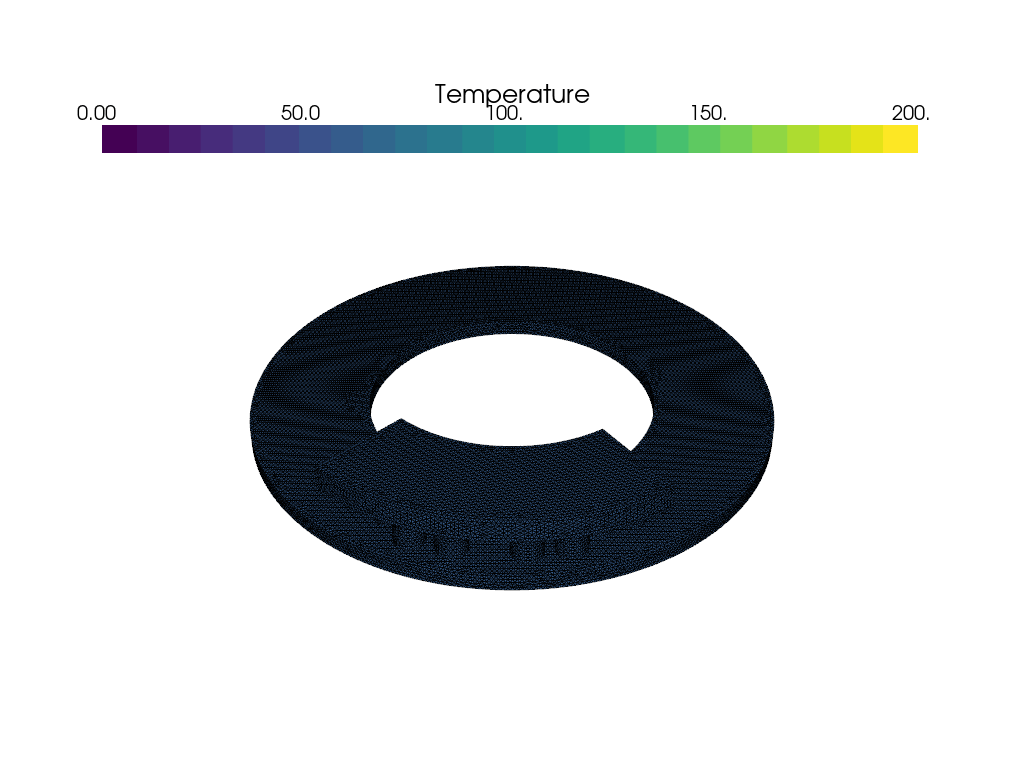

In [1]:
from disc_f import *

# mesh-size, contact area coefficient
mesh_min, mesh_max = 3, 5
c_contact          = 1
# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r          = 224
v_vehicle, c_acc   = 160, 1
z1,z2,z3,z_all     = 20,33,30,8
pad_v_tag          = 32
# calling local functions to get all parameters
(dt, P, g, num_steps, h, radiation, v_angular, Ti, Tm, S_rub_circle, t, rho, c, k, t_brake, 
S_total,) = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)
print("1: Total braking tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)

## here use lots of abbreviation, details are in disc_f
domain, cell_markers, facet_markers, mesh_name, mesh_name1, mesh_name2 \
                       = mesh_brake_all(mesh_min,mesh_max,pad_v_tag)
V, T_init, u_n         = initial_u_n(domain, Ti)
fdim, bc, mesh_brake, all_e,xdmf, x_co, y_co, ds, b_con \
                       = mesh_setup(domain, V,mesh_name1,num_steps, \
                         angular_r, mesh_name2, c_contact,z_all,Tm, S_rub_circle)
# Initialize
problem,u,v,f,n_vector = variation_initial(V, T_init,domain, rho, c, b_con,\
                          radiation, h, k, xdmf,dt,ds,u_n, Tm,g,bc);
n,converged = solver_setup_solve(problem,u)

## Visualization of time dependent problem using pyvista
gif_name    = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(num_steps, angular_r, mesh_name2, c_contact, all_e)
plotter, sargs, renderer, warped, viridis, grid = plot_gif(V,u,gif_name)
##solve
#num_steps= int(num_steps/10/6)
num_steps= int(10) # just do one step to check the deformation.

T_array     = solve_heat(Ti, u, num_steps, dt, x_co, y_co, angular_r,t_brake, \
                     domain,S_rub_circle,fdim, rho, c, v, radiation, k, h, \
                     f,Tm,u_n,g, ds, xdmf, b_con,bc,plotter,warped)

csv_name    = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(num_steps, angular_r, mesh_name2, c_contact, all_e  )
# got the Temperature data
save_t_T(csv_name, T_array)

from IPython.display import display, Image
display(Image(gif_name))

# 2: New brake pad points, add boundary for rubbing elements

Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57455 nodes
Info    : 271817 elements
Info    : Done reading 'm-3-5.msh'                                         
Volume:, Tag:31
Volume:, Tag:32
Info    : Meshing 1D...
Info    : Done meshing 1D (Wall 5.8667e-05s, CPU 6e-05s)
Info    : Meshing 2D...
Info    : Done meshing 2D (Wall 0.000345015s, CPU 0.000351s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 1.01581s, CPU 1.01868s)
Info    : Optimizing mesh...
Info    : Done optimizing mesh (Wall 0.0190429s, CPU 0.018373s)
Info    : 57455 nodes 271865 elements
Info    : Writing 'new_pad.msh'...
Info    : Done writing 'new_pad.msh'
Info    : Reading 'm-3-5.msh'...
Info    : 168 entities
Info    : 57455 nodes
Info    : 271817 elements
Info    : Done reading 'm-3-5.msh'                                         
Info    : Reading 'new_pad.msh'...
Info    : 168 entities
Info    : 17025 nodes
Info    : 78227 elements
Info    : Done reading 'new_pad.msh'
Info    : Reading

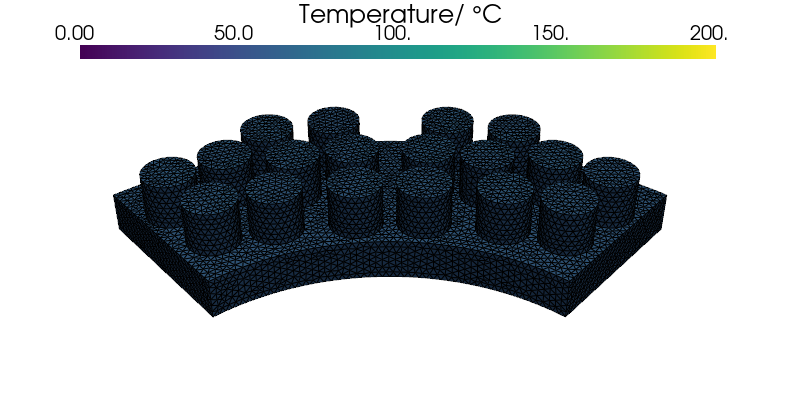

In [2]:
## plot the temperature
mesh_n_pad = mesh_del_disc(mesh_name1, "new_pad.msh")
T_new_p, pad_node_coordinates  = T_pad_transfer1( mesh_name1, mesh_n_pad, u_n, mesh_brake, pad_v_tag )
domain_pad, cell_mark_pad, facet_mark_pad = gmshio.read_from_msh( mesh_n_pad , MPI.COMM_WORLD, 0, gdim=3 )
plot_T_pad( domain_pad, T_new_p).show()

# defin the pad domain
VT      = fem.functionspace(domain_pad, ("CG", 1))         #define the finite element function space
Delta_T = fem.Function(VT, name ="Temperature_variation")  # T_ is the test function, like v


In [4]:


T_new_p1 = []
for i in range(len(T_new_p)):
    T_new_p1 = T_new_p1 + [60]

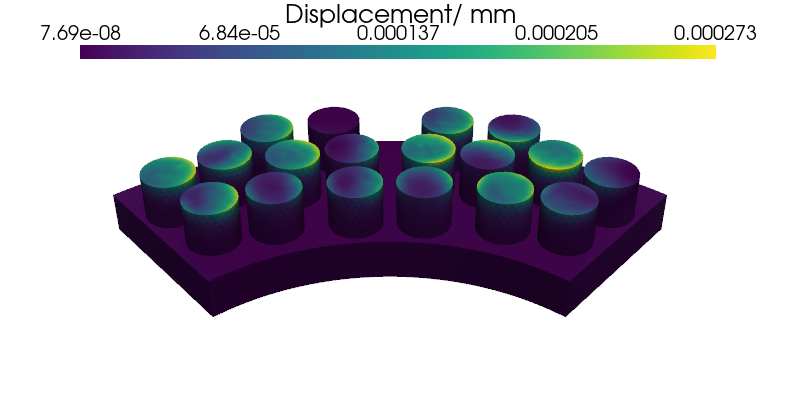

In [5]:



for i in range(len(T_new_p)): 
    Delta_T.x.array[i] = T_new_p[i]-T_new_p1[i]    #Delta_T is the nodes temperature. 

#######try to make domain only for brake pad.
E    = fem.Constant(domain_pad, 1.8e5)            # Elastic module
nu   = fem.Constant(domain_pad, 0.2)              # Poission ratio
gdim = domain_pad.geometry.dim

mu    = E / 2 / (1 + nu)                          # Shear modulus
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)          # Lame parameters
#alpha = fem.Constant(domain_pad, 1.5e-6)         # Thermal expansion coefficient
alpha = fem.Constant(domain_pad, 1.5e-5)   
f1    = fem.Constant(domain_pad, (0.0, 0.0, 0.0)) # O for external force

def eps(v):                                       # epsilon, strain, the deforamtion, dy/y 
    return ufl.sym(ufl.grad(v))
def sigma(v, Delta_T):                            # sigmathis is sigma
    return (lmbda * ufl.tr(eps(v)) - alpha * (3 * lmbda + 2 * mu) * Delta_T 
    ) * ufl.Identity(gdim)  + 2.0 * mu * eps(v)   # here braces is important, can not be in above line

Vu = fem.functionspace(domain_pad, ("CG", 1, (gdim,))) 
du = ufl.TrialFunction(Vu)
u_ = ufl.TestFunction(Vu)

Wint = ufl.inner(sigma(du, Delta_T), eps(u_)) * ufl.dx  # here du is unkown
aM   = ufl.lhs(Wint)                                    # Wint is long and lhs can help to distinguish unkown and know.
LM   = ufl.rhs(Wint) + ufl.inner(f1, u_) * ufl.dx       # knows parameters are in lhs

def up_side(x):
    return np.isclose(x[2], (5))
    #return np.isclose(x[2], (z1+z2+z3))

up_dofs_u = fem.locate_dofs_geometrical(Vu, up_side)    # lateral sides of domain
bcu       = [fem.dirichletbc(np.zeros((gdim,)), up_dofs_u, Vu)]  # displacement Vu is fixed in lateral sides

u_d     = fem.Function(Vu, name="Displacement")
problem = fem.petsc.LinearProblem(aM, LM, u=u_d, bcs=bcu)
problem.solve()

scale_factor = 100
plot_s_pad = plot_S_pad(Vu,u_d,scale_factor )
plot_s_pad.show()


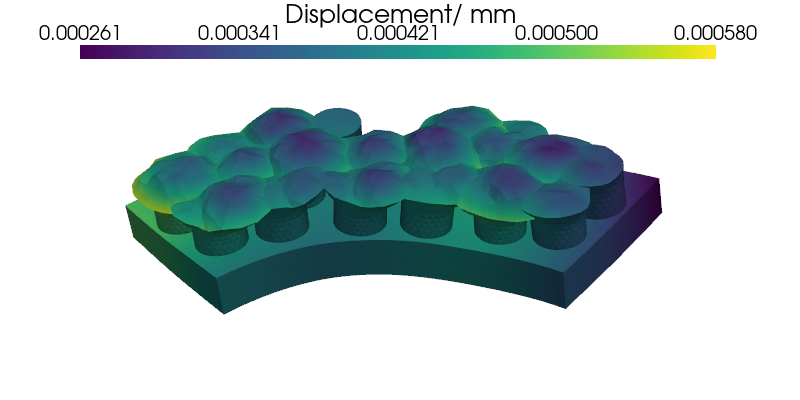

In [13]:
scale_factor = 10000
plot_s_pad = plot_S_pad(Vu,u_d,scale_factor )
plot_s_pad.show()

## Penalty method

[ 1.91999884e-05  3.21069582e-05 -1.27194039e-05  6.44635482e-06
  1.86389131e-05 -4.85538865e-06  3.51005416e-06  1.77921034e-06
  3.24634888e-05 -9.30613429e-06  3.98870568e-05 -8.63374588e-07
  2.90778969e-05  5.34324481e-05  6.54354220e-05 -1.36624527e-05
 -8.20715606e-07 -2.09375917e-05 -1.02587983e-05  1.84432983e-05
 -2.14448714e-05  2.74546526e-05  5.24440636e-05  3.67317425e-05
  7.24697565e-06  1.52070740e-07  1.57068397e-05  1.36133465e-06
 -4.73224659e-06 -1.59967898e-05  4.16077638e-05  3.03194025e-05
  1.21743217e-05  2.13705950e-05 -9.89873854e-08  9.01504634e-07
  9.53430755e-06  4.70056560e-05  2.36155597e-05  1.60873637e-05
  1.35594418e-05  2.59567138e-06 -1.07373716e-05  9.66548355e-06
  5.32702547e-06 -1.31584342e-05 -9.91055600e-06  1.24047997e-06
 -5.06054999e-06 -1.82065053e-05  9.45458829e-06  4.31088122e-05
  3.53152027e-05  1.27979420e-05  1.40262696e-05  6.26306019e-06
  7.77068075e-06  3.70765666e-05  7.05577789e-06  5.14824673e-05
 -3.57266823e-04 -3.32777

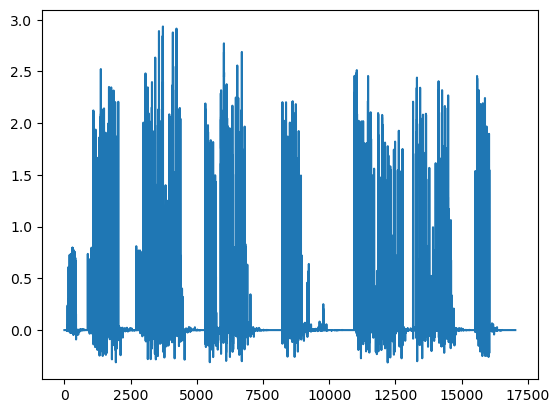

In [6]:
np.set_printoptions(threshold=np.inf)
plt.plot(Delta_T.x.array)
print( Delta_T.x.array )

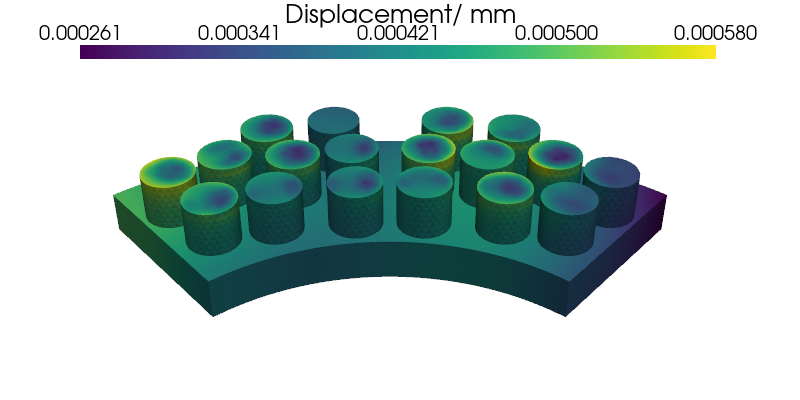

In [7]:
def bottom_contact_nodes(x):
    return np.isclose(x[2], z1)
contact_dofs = fem.locate_dofs_geometrical(Vu, bottom_contact_nodes)
penalty_param = 400
# Create a function to store penalty forces in the same function space as displacement
penalty_forces = fem.Function(Vu)
def update_penalty_force(u_d, penalty_forces, z1, penalty_param):
    u_vals = u_d.x.array.reshape(-1, gdim)
    penalty_forces_vals = penalty_forces.x.array.reshape(-1, gdim)
    # Apply penalty force for nodes below z1
    for dof in contact_dofs:
        if u_vals[dof][2] < 0:  ## here should <0 because contact surface is minus once expend with no constrain.
            penalty_forces_vals[dof][2] = -penalty_param * ( u_vals[dof][2]) # if here is not minus, rubing element grew up
        else:
            penalty_forces_vals[dof][2] = 0.0  # No penalty force if above z1
    penalty_forces.x.array[:] = penalty_forces_vals.ravel()

u_d = fem.Function(Vu, name="Displacement")
problem = fem.petsc.LinearProblem(aM, LM, u=u_d, bcs=bcu)
problem.solve()


update_penalty_force(u_d, penalty_forces, z1, penalty_param)
u_d = fem.Function(Vu, name="Displacement")
LM_penalized = LM + ufl.inner(penalty_forces, u_) * ufl.dx
problem = fem.petsc.LinearProblem(aM, LM_penalized, u=u_d, bcs=bcu)
problem.solve()

scale_factor = 1
plot_s_pad = plot_S_pad(Vu, u_d, scale_factor)
plot_s_pad.show()


## Get contact zone nodes

In [ ]:
x_co_zone   = 0.01
deformed_co, new_c = get_new_contact_nodes(x_co_zone, domain_pad, u_d,  Vu, z1, x_co, y_co )
x_co_new, y_co_new, r_rub_new, S_total_new,S_rub_circle_new = get_r_xco_yco (deformed_co, new_c )
fraction_c = []
fraction_c.append( (S_total_new)/(200) )
print('Total contact surface is: ', round(S_total_new, 2), " mm")
print("Contact friction is ", fraction_c)

In [ ]:
vtk = io.VTKFile(domain_pad.comm, "pad_deformation", "w")
vtk.write_function(u_d)
vtk.close()